# LIBRARIES IMPORTATION

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score, f1_score,roc_curve,auc,r2_score,mean_squared_error,mean_absolute_error
import warnings
from sklearn.svm import SVC,SVR
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
warnings.filterwarnings("ignore")
import talib
import xgboost
import lightgbm
from sklearn.feature_selection import SelectKBest,f_classif
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,Reshape,Conv1D, MaxPooling1D,Flatten

# DATASET IMPORTATION AND MERGING

In [2]:
amx=pd.read_csv('American_express.csv')
fiv=pd.read_csv('Fiserv.csv')
vis=pd.read_csv('Visa.csv')
pay=pd.read_csv('Paypal.csv')
mst=pd.read_csv('Mastercard.csv')
amx['Company']='AMX'
fiv['Company']='FI'
vis['Company']='V'
pay['Company']='PYL'
mst['Company']='MA'
r=pd.read_csv('macro_data.csv')
# df=pd.concat([amx,fiv,vis,pay,mst],ignore_index=True)
# df=df.sort_values('Date')


In [3]:
amx_macro=pd.merge(amx,r,on='Date',how='inner')
fiv_macro=pd.merge(fiv,r,on='Date',how='inner')
vis_macro=pd.merge(vis,r,on='Date',how='inner')
pay_macro=pd.merge(pay,r,on='Date',how='inner')
mst_macro=pd.merge(mst,r,on='Date',how='inner')

In [4]:
amx_macro

,Date,Close price,Revenue,Net income,D/E Ratio,ROIC,Company,S&P index
0,1/3/2017,68.333771,9152.0,1220,2.00,0.11,AMX,2257.830078
1,1/4/2017,69.453979,9152.0,1220,2.00,0.11,AMX,2270.750000
2,1/5/2017,68.597885,9152.0,1220,2.00,0.11,AMX,2269.000000
3,1/6/2017,68.734497,9152.0,1220,2.00,0.11,AMX,2276.979980
4,1/9/2017,69.089684,9152.0,1220,2.00,0.11,AMX,2268.899902
...,...,...,...,...,...,...,...,...
1505,12/23/2022,145.472565,15383.0,1546,1.62,0.15,AMX,3844.820068
1506,12/27/2022,144.849182,15383.0,1546,1.62,0.15,AMX,3829.250000
1507,12/28/2022,142.494217,15383.0,1546,1.62,0.15,AMX,3783.219971
1508,12/29/2022,145.769379,15383.0,1546,1.62,0.15,AMX,3849.280029


In [5]:
s=amx_macro

# FEATURE ENGINEERING

In [6]:
def feature_engineer(data):   
    data['rsi'] = talib.RSI(data['Close price'].values, timeperiod=14)
    data["7MA"]=talib.MA(data['Close price'],timeperiod=7)
    data["14MA"]=talib.MA(data['Close price'],timeperiod=14)
    data["21MA"]=talib.MA(data['Close price'],timeperiod=21)
    data["STD7"]=talib.STDDEV(data['Close price'],timeperiod=7)
    macd,sg,hist=talib.MACD(data['Close price'])
    data['MACD']=macd
    data['MACD_s']=sg
    data['Date']=pd.to_datetime(data['Date'])
    returns=data['Close price'].pct_change()
    data['returns']=returns
    data=data.dropna()
    threshold=0.01
    data['signal']=returns.apply(lambda x:1 if x>threshold else 0)
    data=data.dropna()
    return data

In [7]:
a=feature_engineer(mst_macro)
b=feature_engineer(amx_macro)
c=feature_engineer(pay_macro)
d=feature_engineer(fiv_macro)
e=feature_engineer(vis_macro)

In [8]:
a

,Date,Close price,Revenue,Net income,D/E Ratio,ROIC,Company,S&P index,rsi,7MA,14MA,21MA,STD7,MACD,MACD_s,returns,signal
33,2017-02-21,106.153831,2734.0,1081.0,2.29,0.59,MA,2365.379883,67.577988,105.031903,103.721363,104.232547,0.859831,0.386950,0.036010,0.006763,0
34,2017-02-22,105.460045,2734.0,1081.0,2.29,0.59,MA,2362.820068,61.605510,105.330631,104.026973,104.223829,0.530282,0.412719,0.111352,-0.006536,0
35,2017-02-23,106.712746,2734.0,1081.0,2.29,0.59,MA,2363.810059,67.236073,105.669278,104.412427,104.261456,0.547579,0.528136,0.194708,0.011878,1
36,2017-02-24,106.963303,2734.0,1081.0,2.29,0.59,MA,2367.340088,68.239339,105.961123,104.716660,104.298625,0.611362,0.632530,0.282273,0.002348,0
37,2017-02-27,106.548950,2734.0,1081.0,2.29,0.59,MA,2369.750000,64.710409,106.086395,104.990608,104.353231,0.628884,0.674059,0.360630,-0.003874,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,2022-12-23,342.011322,5817.0,2525.0,5.09,0.61,MA,3844.820068,49.414313,342.282928,346.596464,348.251391,1.922445,1.865557,4.234156,0.006090,0
1506,2022-12-27,344.559479,5817.0,2525.0,5.09,0.61,MA,3829.250000,51.749109,342.270129,346.499056,348.008234,1.906883,1.709527,3.729230,0.007451,0
1507,2022-12-28,340.368958,5817.0,2525.0,5.09,0.61,MA,3783.219971,47.838658,341.716984,346.110149,347.883102,1.814304,1.233513,3.230087,-0.012162,0
1508,2022-12-29,346.600037,5817.0,2525.0,5.09,0.61,MA,3849.280029,53.469133,342.705248,345.899700,348.123890,2.264920,1.343577,2.852785,0.018307,1


In [9]:
b

,Date,Close price,Revenue,Net income,D/E Ratio,ROIC,Company,S&P index,rsi,7MA,14MA,21MA,STD7,MACD,MACD_s,returns,signal
33,2017-02-21,72.832870,9152.0,1220,2.00,0.11,AMX,2365.379883,72.575379,72.286429,71.456342,70.958467,0.429039,0.848603,0.657424,0.003261,0
34,2017-02-22,72.732712,9152.0,1220,2.00,0.11,AMX,2362.820068,71.036916,72.465982,71.658011,71.127173,0.293981,0.859941,0.697927,-0.001375,0
35,2017-02-23,72.905762,9152.0,1220,2.00,0.11,AMX,2363.810059,72.135954,72.614307,71.888302,71.240800,0.202194,0.872828,0.732907,0.002379,0
36,2017-02-24,72.641640,9152.0,1220,2.00,0.11,AMX,2367.340088,67.900881,72.659848,72.000196,71.365271,0.163647,0.851909,0.756708,-0.003623,0
37,2017-02-27,73.015045,9152.0,1220,2.00,0.11,AMX,2369.750000,70.534668,72.734009,72.153074,71.505788,0.188322,0.855598,0.776486,0.005140,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,2022-12-23,145.472565,15383.0,1546,1.62,0.15,AMX,3844.820068,42.669787,145.121988,149.346339,150.798274,1.612605,-1.358160,-0.158645,0.011768,1
1506,2022-12-27,144.849182,15383.0,1546,1.62,0.15,AMX,3829.250000,41.582495,144.580606,148.759016,150.432640,0.742377,-1.477028,-0.422322,-0.004285,0
1507,2022-12-28,142.494217,15383.0,1546,1.62,0.15,AMX,3783.219971,37.676672,144.256906,147.998532,150.109412,1.031309,-1.741185,-0.686094,-0.016258,0
1508,2022-12-29,145.769379,15383.0,1546,1.62,0.15,AMX,3849.280029,45.363045,144.583433,147.517929,149.774875,1.094698,-1.667038,-0.882283,0.022985,1


In [10]:
c

,Date,Close price,Revenue,Net income,D/E Ratio,ROIC,Company,S&P index,rsi,7MA,14MA,21MA,STD7,MACD,MACD_s,returns,signal
626,2019-07-01,115.029999,4378,462,2.05,0.47,PYL,2964.330078,53.769705,114.922857,115.708572,114.331429,0.983430,1.001838,1.365437,0.004980,0
627,2019-07-02,116.169998,4378,462,2.05,0.47,PYL,2973.010010,56.921073,114.917143,115.827857,114.838571,0.976022,1.025438,1.297437,0.009910,0
628,2019-07-03,117.680000,4378,462,2.05,0.47,PYL,2995.820068,60.738711,115.085714,115.967857,115.264762,1.287155,1.152699,1.268489,0.012998,1
629,2019-07-05,117.160004,4378,462,2.05,0.47,PYL,2990.409912,58.806035,115.474286,116.038572,115.569048,1.435578,1.197787,1.254349,-0.004419,0
630,2019-07-08,116.949997,4378,462,2.05,0.47,PYL,2975.949951,58.003314,115.874285,116.023572,115.815238,1.400520,1.202710,1.244021,-0.001792,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,2022-12-23,69.029999,7383,921,2.88,0.13,PYL,3844.820068,31.367998,69.078571,71.294285,73.380476,0.360016,-3.390724,-3.246922,0.006708,0
1506,2022-12-27,68.330002,7383,921,2.88,0.13,PYL,3829.250000,29.943668,68.872857,71.015714,72.820953,0.314720,-3.345892,-3.266716,-0.010140,0
1507,2022-12-28,67.550003,7383,921,2.88,0.13,PYL,3783.219971,28.396387,68.628572,70.525000,72.231429,0.517642,-3.334859,-3.280344,-0.011415,0
1508,2022-12-29,70.559998,7383,921,2.88,0.13,PYL,3849.280029,41.054557,68.858572,70.263571,71.894286,0.856277,-3.048098,-3.233895,0.044560,1


In [11]:
d

,Date,Close price,Revenue,Net income,D/E Ratio,ROIC,Company,S&P index,rsi,7MA,14MA,21MA,STD7,MACD,MACD_s,returns,signal
33,2017-02-21,56.195000,1394.0,247.0,3.00,0.21,FI,2365.379883,70.849021,55.429286,54.431786,54.317619,0.537717,0.316269,-0.075396,0.003661,0
34,2017-02-22,56.910000,1394.0,247.0,3.00,0.21,FI,2362.820068,75.049296,55.768572,54.733214,54.440476,0.610730,0.441800,0.028043,0.012724,1
35,2017-02-23,57.450001,1394.0,247.0,3.00,0.21,FI,2363.810059,77.666592,56.111429,55.070357,54.592381,0.765220,0.578193,0.138073,0.009489,0
36,2017-02-24,58.150002,1394.0,247.0,3.00,0.21,FI,2367.340088,80.519335,56.551429,55.412500,54.777143,0.911431,0.734305,0.257320,0.012185,1
37,2017-02-27,57.790001,1394.0,247.0,3.00,0.21,FI,2369.750000,75.199338,56.872858,55.724286,54.961191,0.894651,0.819528,0.369761,-0.006191,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,2022-12-23,100.459999,4631.0,782.0,1.66,0.07,FI,3844.820068,49.824700,99.488571,100.378571,101.338571,0.942010,-0.174386,0.047125,0.009242,0
1506,2022-12-27,100.820000,4631.0,782.0,1.66,0.07,FI,3829.250000,50.924083,99.824285,100.412143,101.259047,0.937928,-0.123739,0.012952,0.003584,0
1507,2022-12-28,99.910004,4631.0,782.0,1.66,0.07,FI,3783.219971,48.057649,100.014286,100.370714,101.170952,0.789609,-0.155240,-0.020686,-0.009026,0
1508,2022-12-29,101.500000,4631.0,782.0,1.66,0.07,FI,3849.280029,53.032264,100.418572,100.373572,101.170000,0.719174,-0.051314,-0.026812,0.015914,1


In [12]:
e

,Date,Close price,Revenue,Net income,D/E Ratio,ROIC,Company,S&P index,rsi,7MA,14MA,21MA,STD7,MACD,MACD_s,returns,signal
33,2017-02-21,84.313103,4477.0,430.0,1.52,0.19,V,2365.379883,76.562331,83.434627,82.266430,81.403013,0.700682,1.674570,1.517734,0.005260,0
34,2017-02-22,84.198021,4477.0,430.0,1.52,0.19,V,2362.820068,75.245726,83.717277,82.644308,81.668150,0.532330,1.669251,1.548037,-0.001365,0
35,2017-02-23,84.562447,4477.0,430.0,1.52,0.19,V,2363.810059,76.617009,83.978150,83.057788,81.901415,0.424149,1.675131,1.573456,0.004328,0
36,2017-02-24,84.802170,4477.0,430.0,1.52,0.19,V,2367.340088,77.499977,84.217210,83.229960,82.115558,0.341590,1.679772,1.594719,0.002835,0
37,2017-02-27,84.389809,4477.0,430.0,1.52,0.19,V,2369.750000,72.433164,84.280225,83.389770,82.340148,0.326604,1.631370,1.602050,-0.004863,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,2022-12-23,205.027924,7936.0,4179.0,1.44,0.34,V,3844.820068,46.801923,205.294028,207.639141,209.550233,1.047750,-0.023868,1.179243,0.003755,0
1506,2022-12-27,205.486115,7936.0,4179.0,1.44,0.34,V,3829.250000,47.637854,205.063498,207.440630,209.194482,0.764241,-0.137478,0.915899,0.002235,0
1507,2022-12-28,204.191208,7936.0,4179.0,1.44,0.34,V,3783.219971,45.463577,204.793130,207.239987,208.897074,0.686259,-0.328219,0.667075,-0.006302,0
1508,2022-12-29,207.249237,7936.0,4179.0,1.44,0.34,V,3849.280029,51.135659,205.254181,207.165991,208.849641,1.017442,-0.229975,0.487665,0.014976,1


In [13]:
df=pd.concat([a,b,c,d,e],ignore_index=True)
df=df.sort_values('Date')
# df.to_csv('merged_data.csv')

<AxesSubplot:>

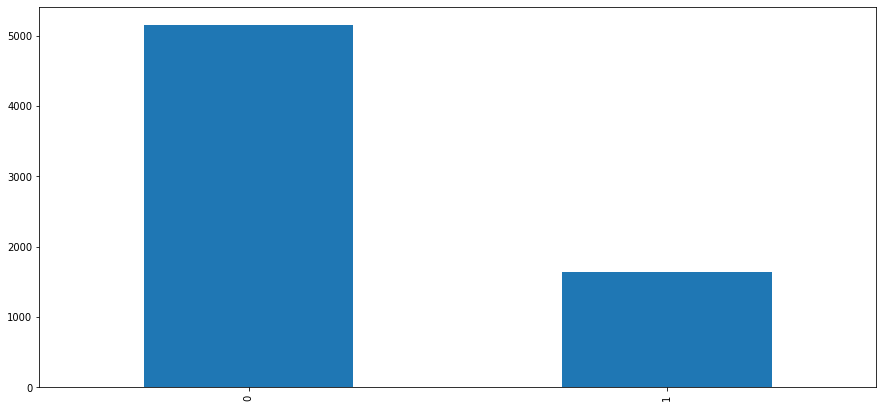

In [14]:
plt.figure(figsize=(15,7))
df.signal.value_counts().plot.bar()

# DATA EXPLORATION

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6792 entries, 0 to 6791
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         6792 non-null   datetime64[ns]
 1   Close price  6792 non-null   float64       
 2   Revenue      6792 non-null   float64       
 3   Net income   6792 non-null   float64       
 4   D/E Ratio    6792 non-null   float64       
 5   ROIC         6792 non-null   float64       
 6   Company      6792 non-null   object        
 7   S&P index    6792 non-null   float64       
 8   rsi          6792 non-null   float64       
 9   7MA          6792 non-null   float64       
 10  14MA         6792 non-null   float64       
 11  21MA         6792 non-null   float64       
 12  STD7         6792 non-null   float64       
 13  MACD         6792 non-null   float64       
 14  MACD_s       6792 non-null   float64       
 15  returns      6792 non-null   float64       
 16  signal

In [16]:
df.corr()

,Close price,Revenue,Net income,D/E Ratio,ROIC,S&P index,rsi,7MA,14MA,21MA,STD7,MACD,MACD_s,returns,signal
Close price,1.000000,-0.054618,0.497051,0.539190,0.625297,0.462124,-0.020220,0.998278,0.996496,0.994785,0.568484,0.145443,0.148947,0.017274,0.071629
Revenue,-0.054618,1.000000,0.258663,-0.383645,-0.338268,0.245889,-0.096879,-0.053186,-0.051382,-0.049706,0.018470,-0.075985,-0.078158,-0.011077,0.022031
Net income,0.497051,0.258663,1.000000,-0.049745,0.371651,0.208562,0.006313,0.496115,0.494986,0.494115,0.204772,0.079084,0.081944,0.012180,0.007261
D/E Ratio,0.539190,-0.383645,-0.049745,1.000000,0.623005,-0.039948,-0.005756,0.539469,0.539650,0.539680,0.329237,0.040510,0.044864,0.000010,0.020469
ROIC,0.625297,-0.338268,0.371651,0.623005,1.000000,-0.143640,0.101331,0.624496,0.623421,0.622247,0.274877,0.104264,0.112836,0.008188,-0.007990
S&P index,0.462124,0.245889,0.208562,-0.039948,-0.143640,1.000000,-0.249737,0.463938,0.466184,0.468444,0.336531,-0.086957,-0.101215,-0.010589,0.073619
rsi,-0.020220,-0.096879,0.006313,-0.005756,0.101331,-0.249737,1.000000,-0.053270,-0.079048,-0.097204,-0.287384,0.678325,0.549964,0.298055,0.108120
7MA,0.998278,-0.053186,0.496115,0.539469,0.624496,0.463938,-0.053270,1.000000,0.999033,0.997554,0.576990,0.129937,0.145215,-0.014871,0.052009
14MA,0.996496,-0.051382,0.494986,0.539650,0.623421,0.466184,-0.079048,0.999033,1.000000,0.999388,0.586987,0.099554,0.124980,-0.015894,0.053471
21MA,0.994785,-0.049706,0.494115,0.539680,0.622247,0.468444,-0.097204,0.997554,0.999388,1.000000,0.595420,0.070425,0.098266,-0.016207,0.055485


In [17]:
df.describe()

,Close price,Revenue,Net income,D/E Ratio,ROIC,S&P index,rsi,7MA,14MA,21MA,STD7,MACD,MACD_s,returns,signal
count,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000,6792.000000
mean,160.218993,6055.607185,1529.876914,2.387117,0.258364,3362.148245,54.000783,160.027088,159.802463,159.568135,2.739317,0.466766,0.469463,0.000650,0.241313
std,81.436490,3140.795692,1074.330745,1.101618,0.195496,709.846511,11.305120,81.298043,81.163109,81.030183,2.630388,3.466509,3.226822,0.021043,0.427911
min,56.195000,1386.000000,-1215.000000,1.180000,0.030000,2237.399902,19.971630,55.429286,54.431786,54.317619,0.058608,-25.756782,-20.502754,-0.245904,0.000000
25%,99.072838,4045.000000,507.000000,1.560000,0.110000,2759.820068,46.357494,99.063278,98.906406,98.658809,1.009734,-0.677999,-0.634891,-0.008312,0.000000
50%,128.655670,5240.000000,1567.000000,1.940000,0.210000,3155.219971,54.478930,128.391006,127.973474,127.626409,1.942181,0.719740,0.700523,0.001131,0.000000
75%,203.894775,7275.000000,2249.000000,2.940000,0.330000,3972.889893,62.134807,202.957492,202.162550,201.936993,3.497620,1.998529,1.904245,0.009660,0.000000
max,393.130463,15383.000000,4179.000000,6.710000,0.760000,4796.560059,86.201786,383.567932,380.396801,377.107558,22.544996,16.389697,13.472552,0.218823,1.000000


In [18]:
df.shape

(6792, 17)

Text(0.5, 1.0, 'Daily returns for American Express Company')

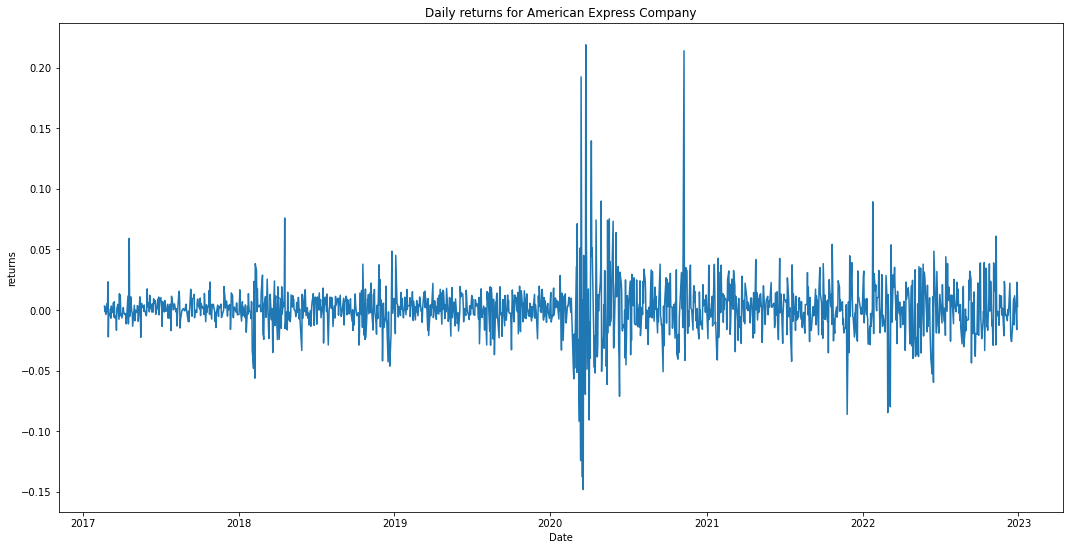

In [19]:
amx=df[df['Company']=='AMX']
plt.figure(figsize=(18,9))
sns.lineplot(y='returns',x='Date',data=amx)
plt.title('Daily returns for American Express Company')

Text(0.5, 1.0, 'Daily returns for MasterCard Company')

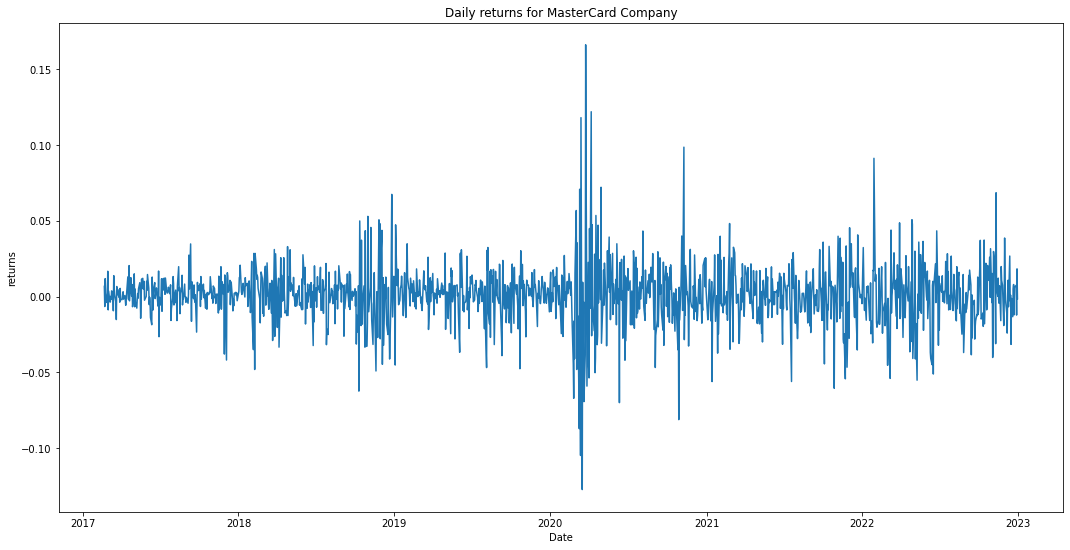

In [20]:
ma=df[df['Company']=='MA']
plt.figure(figsize=(18,9))
sns.lineplot(y='returns',x='Date',data=ma)
plt.title('Daily returns for MasterCard Company')

Text(0.5, 1.0, 'Daily returns for Visa Company')

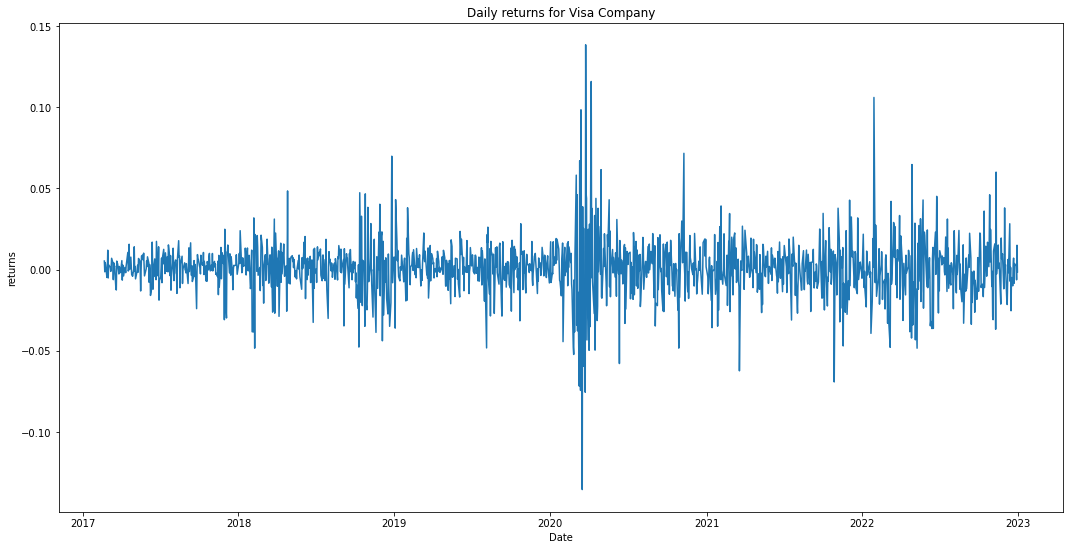

In [21]:
v=df[df['Company']=='V']
plt.figure(figsize=(18,9))
sns.lineplot(y='returns',x='Date',data=v)
plt.title('Daily returns for Visa Company')

Text(0.5, 1.0, 'Daily returns for Fiserv Company')

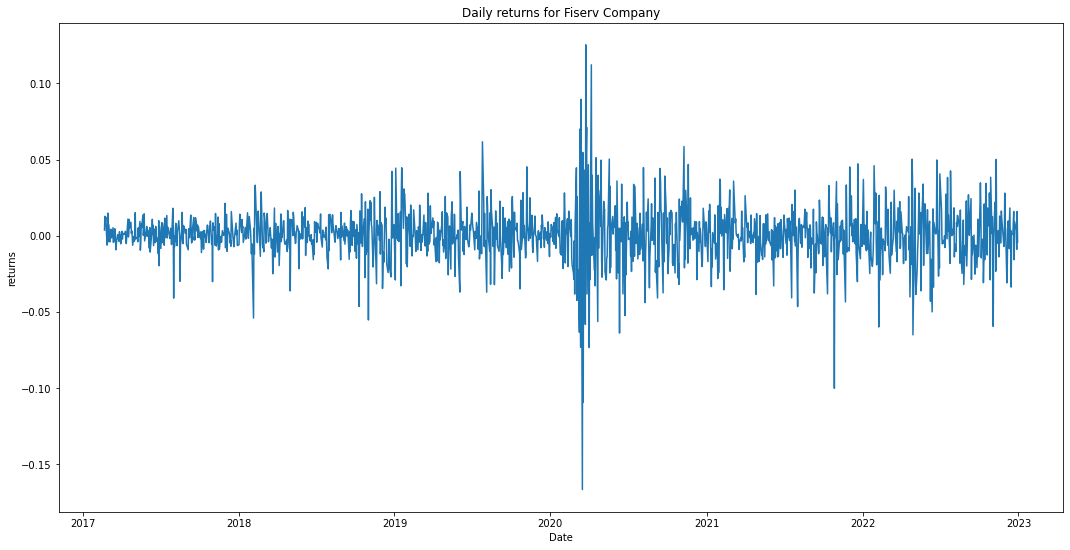

In [22]:
fi=df[df['Company']=='FI']
plt.figure(figsize=(18,9))
sns.lineplot(y='returns',x='Date',data=fi)
plt.title('Daily returns for Fiserv Company')

Text(0.5, 1.0, 'Daily returns for Paypal Company')

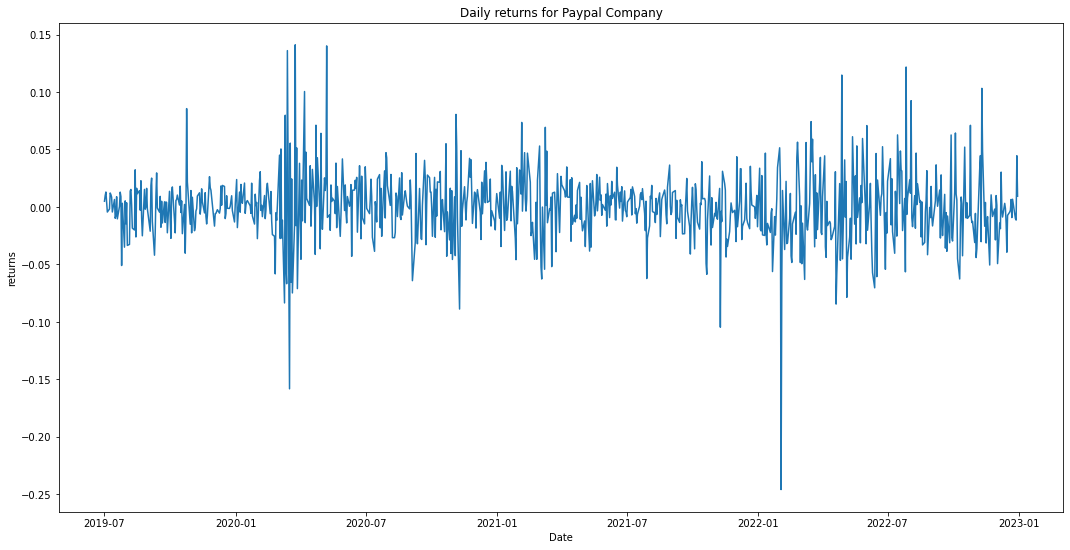

In [23]:
pyl=df[df['Company']=='PYL']
plt.figure(figsize=(18,9))
sns.lineplot(y='returns',x='Date',data=pyl)
plt.title('Daily returns for Paypal Company')

# DATA SPLITTING

In [24]:
data=df

In [25]:
T='2021-01-01'
training=data[df['Date']<T]
testing=data[data['Date']>=T]

In [26]:
x=training.drop(['Company','Date','signal','returns'],axis=1)
y=training['returns']

In [27]:
x

,Close price,Revenue,Net income,D/E Ratio,ROIC,S&P index,rsi,7MA,14MA,21MA,STD7,MACD,MACD_s
0,106.153831,2734.0,1081.0,2.29,0.59,2365.379883,67.577988,105.031903,103.721363,104.232547,0.859831,0.386950,0.036010
3838,56.195000,1394.0,247.0,3.00,0.21,2365.379883,70.849021,55.429286,54.431786,54.317619,0.537717,0.316269,-0.075396
5315,84.313103,4477.0,430.0,1.52,0.19,2365.379883,76.562331,83.434627,82.266430,81.403013,0.700682,1.674570,1.517734
1477,72.832870,9152.0,1220.0,2.00,0.11,2365.379883,72.575379,72.286429,71.456342,70.958467,0.429039,0.848603,0.657424
1,105.460045,2734.0,1081.0,2.29,0.59,2362.820068,61.605510,105.330631,104.026973,104.223829,0.530282,0.412719,0.111352
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4811,113.860001,3832.0,300.0,1.26,0.03,3756.070068,54.993499,112.152856,113.169284,114.161904,1.132201,0.472372,0.939029
2450,116.744560,9741.0,1415.0,1.50,0.06,3756.070068,59.221824,113.892045,114.092055,115.670958,1.790680,1.023635,1.374288
6288,214.921722,5687.0,3126.0,2.12,0.26,3756.070068,66.455443,208.299055,206.733226,206.768083,5.057932,2.210142,1.415347
973,351.495941,4120.0,1785.0,4.18,0.44,3756.070068,65.871206,337.781206,333.197207,333.259338,9.999441,4.341571,2.232420


In [28]:
select=SelectKBest(score_func=f_classif,k=10)
z=select.fit_transform(x,y)
flt=select.get_support()
s=x.columns
print(s[flt])

Index(['Close price', 'D/E Ratio', 'ROIC', 'S&P index', '7MA', '14MA', '21MA',
       'STD7', 'MACD', 'MACD_s'],
      dtype='object')


In [29]:
x=training[['Close price', 'D/E Ratio', 'ROIC', 'S&P index', '7MA', '14MA', '21MA','STD7', 'MACD', 'MACD_s']]
y=training[['returns']]

In [30]:
x_train=training[['Close price', 'D/E Ratio', 'ROIC', 'S&P index', '7MA', '14MA', '21MA','STD7', 'MACD', 'MACD_s']].values
y_train=training['returns'].values
x_test=testing[['Close price', 'D/E Ratio', 'ROIC', 'S&P index', '7MA', '14MA', '21MA','STD7', 'MACD', 'MACD_s']].values
y_test=testing['returns'].values

In [31]:
scaler = MinMaxScaler()
x_train= scaler.fit_transform(x_train)
x_test= scaler.transform(x_test)
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [32]:
rf_1=RandomForestRegressor()
rf_1.fit(x_train,y_train)
y_pred_rf_1=rf_1.predict(x_test)
print('MSE:',mean_squared_error(y_test,y_pred_rf_1))
print('RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_rf_1)))
print('MAE:',mean_absolute_error(y_test,y_pred_rf_1))
print('R-Squared Value:',rf_1.score(x_test,y_test))

MSE: 0.0007603548792181056
RMSE: 0.027574533164100995
MAE: 0.01933827176848436
R-Squared Value: 0.6252722611386474


In [33]:
xg_1=xgboost.XGBRegressor()
xg_1.fit(x_train,y_train)
y_pred_xg_1=xg_1.predict(x_test)
print('MSE:',mean_squared_error(y_test,y_pred_xg_1))
print('RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_xg_1)))
print('MAE:',mean_absolute_error(y_test,y_pred_xg_1))
print('R-Squared Value:',xg_1.score(x_test,y_test))

MSE: 0.000769312735597886
RMSE: 0.027736487441597322
MAE: 0.018579300375958112
R-Squared Value: 0.6444198406324391


In [34]:
lg_1=lightgbm.LGBMRegressor()
lg_1.fit(x_train,y_train)
y_pred_lg_1=lg_1.predict(x_test)
print('MSE:',mean_squared_error(y_test,y_pred_lg_1))
print('RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_lg_1)))
print('MAE:',mean_absolute_error(y_test,y_pred_lg_1))
print('R-Squared Value:',lg_1.score(x_test,y_test))

MSE: 0.000810113721578588
RMSE: 0.028462496755881906
MAE: 0.019721561546049874
R-Squared Value: 0.7316326836797973


In [35]:
dt_1=DecisionTreeRegressor()
dt_1.fit(x_train,y_train)
y_pred_dt_1=dt_1.predict(x_test)
print('MSE:',mean_squared_error(y_test,y_pred_dt_1))
print('RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_dt_1)))
print('MAE:',mean_absolute_error(y_test,y_pred_dt_1))
print('R-Squared Value:',dt_1.score(x_test,y_test))

MSE: 0.0021139974370304273
RMSE: 0.04597822785874231
MAE: 0.029816213050045934
R-Squared Value: -3.518707630385565


In [36]:
svm_1=SVR()
svm_1.fit(x_train,y_train)
y_pred_svm_1=svm_1.predict(x_test)
print('MSE:',mean_squared_error(y_test,y_pred_svm_1))
print('RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_svm_1)))
print('MAE:',mean_absolute_error(y_test,y_pred_svm_1))
print('R-Squared Value:',svm_1.score(x_test,y_test))

MSE: 0.0018831969188894734
RMSE: 0.0433958168362974
MAE: 0.033698757950858506
R-Squared Value: -3.025367362250954


In [37]:
lr_1=LinearRegression()
lr_1.fit(x_train,y_train)
y_pred_lr_1=lr_1.predict(x_test)
print('MSE:',mean_squared_error(y_test,y_pred_lr_1))
print('RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_lr_1)))
print('MAE:',mean_absolute_error(y_test,y_pred_lr_1))
print('R-Squared Value:',(lr_1.score(x_test,y_test)))

MSE: 0.0002371608115992714
RMSE: 0.015400026350603151
MAE: 0.011231249968279703
R-Squared Value: 0.4930644899421246


In [38]:
mlp_1=MLPRegressor()
mlp_1.fit(x_train,y_train)
y_pred_mlp_1=mlp_1.predict(x_test)
print('MSE:',mean_squared_error(y_test,y_pred_mlp_1))
print('RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_mlp_1)))
print('MAE:',mean_absolute_error(y_test,y_pred_mlp_1))
print('R-Squared Value:',mlp_1.score(x_test,y_test))

MSE: 0.006400617409266231
RMSE: 0.08000385871485344
MAE: 0.06058798324913527
R-Squared Value: -12.681435095332008


In [39]:
cnn= Sequential()
cnn.add(Conv1D(64, 3, activation='relu', input_shape=(x_train.shape[1], 1)))
cnn.add(MaxPooling1D(2))
cnn.add(Flatten())
cnn.add(Dropout(0.2))
cnn.add(Dense(1))
cnn.compile(optimizer='adam', loss='mean_absolute_error')
cnn.fit(x_train, y_train, epochs=10)
cnn_pred = cnn.predict(x_test)
print('MAE',mean_absolute_error(y_test,cnn_pred))
print('MSE',mean_squared_error(y_test,cnn_pred))
print('RMSE',np.sqrt(mean_squared_error(y_test,cnn_pred)))
print('R-squared value',r2_score(y_test,cnn_pred))

Epoch 1/10
134/134 [==============================] - 7s 20ms/step - loss: 0.0278
Epoch 2/10
134/134 [==============================] - 3s 21ms/step - loss: 0.0158
Epoch 3/10
134/134 [==============================] - 3s 21ms/step - loss: 0.0151
Epoch 4/10
134/134 [==============================] - 3s 19ms/step - loss: 0.0146
Epoch 5/10
134/134 [==============================] - 3s 22ms/step - loss: 0.0142
Epoch 6/10
134/134 [==============================] - 3s 20ms/step - loss: 0.0145
Epoch 7/10
134/134 [==============================] - 3s 23ms/step - loss: 0.0143
Epoch 8/10
134/134 [==============================] - 3s 22ms/step - loss: 0.0142
Epoch 9/10
134/134 [==============================] - 3s 20ms/step - loss: 0.0143
Epoch 10/10
79/79 [==============================] - 3s 17ms/step
MAE 0.022613167535530627
MSE 0.0008130950061354022
RMSE 0.028514820815418115
R-squared value -0.738005233163183


In [40]:
# Build the LSTM model
lstm = Sequential()
lstm.add(LSTM(50, activation='relu', input_shape=(x_train.shape[1],1)))
lstm.add(Dense(1))
cnn.add(Dropout(0.2))
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(x_train, y_train, epochs=10)
lstm_pred = lstm.predict(x_test)
print('MAE',mean_absolute_error(y_test,lstm_pred))
print('MSE',mean_squared_error(y_test,lstm_pred))
print('RMSE',np.sqrt(mean_squared_error(y_test,lstm_pred)))
print('R-squared value',r2_score(y_test,lstm_pred))


Epoch 1/10
134/134 [==============================] - 24s 69ms/step - loss: 5.5175e-04
Epoch 2/10
134/134 [==============================] - 8s 62ms/step - loss: 4.5908e-04
Epoch 3/10
134/134 [==============================] - 8s 63ms/step - loss: 4.4855e-04
Epoch 4/10
134/134 [==============================] - 9s 65ms/step - loss: 4.4741e-04
Epoch 5/10
134/134 [==============================] - 8s 61ms/step - loss: 4.4124e-04
Epoch 6/10
134/134 [==============================] - 9s 64ms/step - loss: 4.5348e-04
Epoch 7/10
134/134 [==============================] - 10s 74ms/step - loss: 4.2910e-04
Epoch 8/10
134/134 [==============================] - 12s 89ms/step - loss: 4.6490e-04
Epoch 9/10
134/134 [==============================] - 9s 69ms/step - loss: 4.4320e-04
Epoch 10/10
79/79 [==============================] - 5s 31ms/step
MAE 0.01593664553922303
MSE 0.0004891283982067799
RMSE 0.02211624738075562
R-squared value 0.04552076861549792


In [41]:
par_rf= {
    'n_estimators':[150,100,250,300,400],  
    'min_samples_leaf':[1,2,4,6],
    'max_depth':[1,2,5,10],
    'min_samples_split':[2,4,6]
    
}

grid_rf= GridSearchCV(rf_1, par_rf, n_jobs=-1, cv=3,scoring='neg_mean_squared_error')
grid_rf.fit(x_train,y_train)
best_rf= grid_rf.best_params_
print('Best parameters  for RF found:',best_rf)
rf=grid_rf.best_estimator_
rf.fit(x_train,y_train)
y_pred_rf=rf.predict(x_test)
print('MSE:',mean_squared_error(y_test,y_pred_rf))
print('RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_rf)))
print('MAE:',mean_absolute_error(y_test,y_pred_rf))
print('R-Squared Value:',r2_score(y_test,y_pred_rf))
print()
print()




par_xg= {
    'n_estimators':[150,100,300,400],  
    'learning_rate':[0.1,0.001,1.0],
    'max_depth':[3,5,7],
    'subsample':[0.6,0.8,1.0] 
}
grid_xg= GridSearchCV(xg_1, par_xg, n_jobs=-1, cv=3,scoring='neg_mean_squared_error')
grid_xg.fit(x_train,y_train)
best_xg= grid_xg.best_params_
print('Best parameters  for Xgboost found:',best_xg)
xg=grid_xg.best_estimator_
xg.fit(x_train,y_train)
y_pred_xg=xg.predict(x_test)
print('MSE:',mean_squared_error(y_test,y_pred_xg))
print('RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_xg)))
print('MAE:',mean_absolute_error(y_test,y_pred_xg))
print('R-Squared Value:',r2_score(y_test,y_pred_xg))
print()
print()



par_lg= {
    'n_estimators':[100,300,400],  
    'learning_rate':[0.1,0.2,0.4],
    'num_leaves':[5,10,15],
    'boosting_type':['dart','rf','gbdt']
    
}

grid_lg= GridSearchCV(lg_1, par_lg, n_jobs=-1, cv=3,scoring='neg_mean_squared_error')
grid_lg.fit(x_train,y_train)
best_lg= grid_lg.best_params_
print('Best parameters  for lightgbm found:',best_lg)
lg=grid_lg.best_estimator_
lg.fit(x_train,y_train)
y_pred_lg=lg.predict(x_test)
print('MSE:',mean_squared_error(y_test,y_pred_lg))
print('RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_lg)))
print('MAE:',mean_absolute_error(y_test,y_pred_lg))
print('R-Squared Value:',r2_score(y_test,y_pred_lg))

Best parameters  for RF found: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 150}
MSE: 0.00046999812245514857
RMSE: 0.021679440086292554
MAE: 0.015542566666476063
R-Squared Value: 0.004629459337608832


Best parameters  for Xgboost found: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.6}
MSE: 0.0008701976745358092
RMSE: 0.029499113114393953
MAE: 0.02102954536557725
R-Squared Value: 0.860063216250786


Best parameters  for lightgbm found: {'boosting_type': 'dart', 'learning_rate': 0.1, 'n_estimators': 300, 'num_leaves': 10}
MSE: 0.000763336620682599
RMSE: 0.027628547205428646
MAE: 0.019039501504011454
R-Squared Value: 0.6316457872704342


In [42]:
par_lr= {
    'fit_intercept':[x for x in range(1,20)],
    'positive':[True, False],
    
}

grid_lr= GridSearchCV(lr_1, par_lr, n_jobs=-1, cv=3,scoring='neg_mean_squared_error')
grid_lr.fit(x_train,y_train)
best_lr=grid_lr.best_params_
print('Best parameters  for LR found:', best_lr)
lr=grid_lr.best_estimator_
lr.fit(x_train,y_train)
y_pred_lr=lr.predict(x_test)
print('MSE:',mean_squared_error(y_test,y_pred_lr))
print('RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_lr)))
print('MAE:',mean_absolute_error(y_test,y_pred_lr))
print('R-Squared Value:',r2_score(y_test,y_pred_lr))
print()
print()


par_svm= {
    'kernel':['linear','polynomial','radial'],
    'C':[0.1,1,10],
    'gamma':['auto','scale']
}

grid_svm= GridSearchCV(svm_1, par_svm, n_jobs=-1, cv=3,scoring='neg_mean_squared_error')
grid_svm.fit(x_train,y_train)
best_svm=grid_svm.best_params_
print('Best parameters  for SVM found:', best_svm)
svm=grid_svm.best_estimator_
svm.fit(x_train,y_train)
y_pred_svm=svm.predict(x_test)
print('MSE:',mean_squared_error(y_test,y_pred_svm))
print('RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_svm)))
print('MAE:',mean_absolute_error(y_test,y_pred_svm))
print('R-Squared Value:',r2_score(y_test,y_pred_svm))
print()
print()



par_dt= {
    'max_depth':[5,10,20],
    'min_samples_split':[2,4,6],
    'max_features':[2,5,6],
    'min_samples_leaf':[2,4,6]
}

grid_dt= GridSearchCV(dt_1, par_dt, n_jobs=-1, cv=3,scoring='neg_mean_squared_error')
grid_dt.fit(x_train,y_train)
best_dt=grid_dt.best_params_
print('Best parameters  for DT found:', best_dt)
dt=grid_dt.best_estimator_
dt.fit(x_train,y_train)
y_pred_dt=dt.predict(x_test)
print('MSE:',mean_squared_error(y_test,y_pred_dt))
print('RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_dt)))
print('MAE:',mean_absolute_error(y_test,y_pred_dt))
print('R-Squared Value:',r2_score(y_test,y_pred_dt))

Best parameters  for LR found: {'fit_intercept': 1, 'positive': False}
MSE: 0.0002371608115992714
RMSE: 0.015400026350603151
MAE: 0.011231249968279703
R-Squared Value: 0.4930644899421246


Best parameters  for SVM found: {'C': 10, 'gamma': 'auto', 'kernel': 'linear'}
MSE: 0.008982692447936511
RMSE: 0.09477706709925408
MAE: 0.08956995112373731
R-Squared Value: -18.20066703719153


Best parameters  for DT found: {'max_depth': 5, 'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 6}
MSE: 0.0005528669186483924
RMSE: 0.02351312226499051
MAE: 0.016660611138935348
R-Squared Value: -0.18176300506474474


In [43]:
par_ann= {
    'hidden_layer_sizes':[(100,),(50,50),(50,100,50)],
    'activation':['relu','tanh','logistic'],
    'solver':['lbfgs','sgd','adam'],
    'learning_rate':['adaptive','constant'],
    'alpha':[0.0001,0.001,0.1]
    
}

grid_ann= GridSearchCV(mlp_1, par_ann, n_jobs=-1, cv=3,scoring='neg_mean_squared_error')
grid_ann.fit(x_train,y_train)
best_ann=grid_ann.best_params_
print('Best parameters  for ANN found:', best_ann)
ann=grid_ann.best_estimator_
ann.fit(x_train,y_train)
y_pred_ann=ann.predict(x_test)
print('MSE:',mean_squared_error(y_test,y_pred_ann))
print('RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_ann)))
print('MAE:',mean_absolute_error(y_test,y_pred_ann))
print('R-Squared Value:',r2_score(y_test,y_pred_ann))

Best parameters  for ANN found: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
MSE: 0.0012512102715384716
RMSE: 0.03537245074261142
MAE: 0.027101372057526742
R-Squared Value: -1.6744845108042146


In [44]:
T='2021-01-01'
training=df[df['Date']<T]
testing=df[df['Date']>=T]

In [45]:
x=training.drop(['Company','Date','signal'],axis=1)
y=training['signal']

# FEATURE SELECTION

In [46]:
select=SelectKBest(score_func=f_classif,k=10)
z=select.fit_transform(x,y)
flt=select.get_support()
s=x.columns
print(s[flt])

Index(['Close price', 'S&P index', 'rsi', '7MA', '14MA', '21MA', 'STD7',
       'MACD', 'MACD_s', 'returns'],
      dtype='object')


In [47]:
x=training[['Close price', 'S&P index', 'rsi', '7MA', '14MA', '21MA', 'STD7','MACD', 'MACD_s', 'returns']]
y=training[['signal']]

In [48]:
x_train=training[['Close price', 'S&P index', 'rsi', '7MA', '14MA', '21MA', 'STD7','MACD', 'MACD_s', 'returns']].values
y_train=training['signal'].values
x_test=testing[['Close price', 'S&P index', 'rsi', '7MA', '14MA', '21MA', 'STD7','MACD', 'MACD_s', 'returns']].values
y_test=testing['signal'].values

# NORMALIZING AND STANDARDIZING DATA

In [49]:
scaler = MinMaxScaler()
x_train= scaler.fit_transform(x_train)
x_test= scaler.transform(x_test)
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

# ENSEMBLE ALGORITHMS

In [50]:
rf=RandomForestClassifier()
rf.fit(x_train,y_train)
y_pred_rf=rf.predict(x_test)
print('Accuracy Score:',accuracy_score(y_test,y_pred_rf))
print('Precision Score:',precision_score(y_test,y_pred_rf))
print('Recall Score:',recall_score(y_test,y_pred_rf))
print('F1-Score:',f1_score(y_test,y_pred_rf))

Accuracy Score: 1.0
Precision Score: 1.0
Recall Score: 1.0
F1-Score: 1.0


In [51]:
xg=xgboost.XGBClassifier()
xg.fit(x_train,y_train)
y_pred_xg=xg.predict(x_test)
print('Accuracy Score:',accuracy_score(y_test,y_pred_xg))
print('Precision Score:',precision_score(y_test,y_pred_xg))
print('Recall Score:',recall_score(y_test,y_pred_xg))
print('F1-Score:',f1_score(y_test,y_pred_xg))

Accuracy Score: 1.0
Precision Score: 1.0
Recall Score: 1.0
F1-Score: 1.0


In [52]:
lg=lightgbm.LGBMClassifier()
lg.fit(x_train,y_train)
y_pred_lg=lg.predict(x_test)
print('Accuracy Score:',accuracy_score(y_test,y_pred_lg))
print('Precision Score:',precision_score(y_test,y_pred_lg))
print('Recall Score:',recall_score(y_test,y_pred_lg))
print('F1-Score:',f1_score(y_test,y_pred_lg))

Accuracy Score: 0.9980119284294234
Precision Score: 1.0
Recall Score: 0.9925705794947994
F1-Score: 0.9962714392244594


# TRADITIONAL ALGORITHMS

In [53]:
lr=LogisticRegression()
lr.fit(x_train,y_train)
y_pred_lr=lr.predict(x_test)
print('Accuracy Score:',accuracy_score(y_test,y_pred_lr))
print('Precision Score:',precision_score(y_test,y_pred_lr))
print('Recall Score:',recall_score(y_test,y_pred_lr))
print('F1-Score:',f1_score(y_test,y_pred_lr))

Accuracy Score: 0.9932405566600397
Precision Score: 1.0
Recall Score: 0.974739970282318
F1-Score: 0.9872084273890143


In [54]:
svm=SVC(probability=True)
svm=svm.fit(x_train,y_train)
y_pred_svm=svm.predict(x_test)
print('Accuracy Score:',accuracy_score(y_test,y_pred_svm))
print('Precision Score:',precision_score(y_test,y_pred_svm))
print('Recall Score:',recall_score(y_test,y_pred_svm))
print('F1-Score:',f1_score(y_test,y_pred_svm))

Accuracy Score: 0.9335984095427435
Precision Score: 0.9633699633699634
Recall Score: 0.7815750371471025
F1-Score: 0.8630024610336341


In [55]:
dt=DecisionTreeClassifier()
dt.fit(x_train,y_train)
y_pred_dt=dt.predict(x_test)
print('Accuracy Score:',accuracy_score(y_test,y_pred_dt))
print('Precision Score:',precision_score(y_test,y_pred_dt))
print('Recall Score:',recall_score(y_test,y_pred_dt))
print('F1-Score:',f1_score(y_test,y_pred_dt))

Accuracy Score: 1.0
Precision Score: 1.0
Recall Score: 1.0
F1-Score: 1.0


# NEURAL NETWORKS

In [56]:
ann=MLPClassifier()
ann.fit(x_train,y_train)
y_pred_ann=ann.predict(x_test)
print('Accuracy Score:',accuracy_score(y_test,y_pred_ann))
print('Precision Score:',precision_score(y_test,y_pred_ann))
print('Recall Score:',recall_score(y_test,y_pred_ann))
print('F1-Score:',f1_score(y_test,y_pred_ann))

Accuracy Score: 0.984493041749503
Precision Score: 0.9528571428571428
Recall Score: 0.9910846953937593
F1-Score: 0.9715950473415877


In [57]:
cnn= Sequential([
    Reshape(target_shape=(x_train.shape[1], 1), input_shape=(x_train.shape[1],)),
    Conv1D(62, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    cnn.add(Dropout(0.2)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))
y_pred_prob= cnn.predict(x_test)
y_pred_cnn = (y_pred_prob > 0.5).astype(float)
print('Accuracy Score:',accuracy_score(y_test,y_pred_cnn))
print('Precision Score:',precision_score(y_test,y_pred_cnn))
print('Recall Score:',recall_score(y_test,y_pred_cnn))
print('F1-Score:',f1_score(y_test,y_pred_cnn))

Epoch 1/5
134/134 [==============================] - 3s 10ms/step - loss: 0.3677 - accuracy: 0.8391 - val_loss: 0.2290 - val_accuracy: 0.8918
Epoch 2/5
134/134 [==============================] - 1s 5ms/step - loss: 0.1545 - accuracy: 0.9465 - val_loss: 0.1477 - val_accuracy: 0.9280
Epoch 3/5
134/134 [==============================] - 1s 5ms/step - loss: 0.1087 - accuracy: 0.9621 - val_loss: 0.1226 - val_accuracy: 0.9479
Epoch 4/5
134/134 [==============================] - 1s 5ms/step - loss: 0.0917 - accuracy: 0.9701 - val_loss: 0.1702 - val_accuracy: 0.9280
Epoch 5/5
79/79 [==============================] - 0s 2ms/step
Accuracy Score: 0.9590457256461232
Precision Score: 0.96875
Recall Score: 0.87518573551263
F1-Score: 0.9195940671350508


In [58]:
lstm = Sequential([
    Reshape(target_shape=(x_train.shape[1], 1), input_shape=(x_train.shape[1],)),
    LSTM(62, activation='relu'),
    Dropout(0.2),
    Dense(1,activation='sigmoid')
])
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))
y_pred_prob= lstm.predict(x_test)
y_pred_lstm = (y_pred_prob > 0.5).astype(float)
print('Accuracy Score:',accuracy_score(y_test,y_pred_lstm))
print('Precision Score:',precision_score(y_test,y_pred_lstm))
print('Recall Score:',recall_score(y_test,y_pred_lstm))
print('F1-Score:',f1_score(y_test,y_pred_lstm))

Epoch 1/5
134/134 [==============================] - 4s 15ms/step - loss: 0.4925 - accuracy: 0.7870 - val_loss: 0.2852 - val_accuracy: 0.8569
Epoch 2/5
134/134 [==============================] - 2s 12ms/step - loss: 0.3171 - accuracy: 0.8630 - val_loss: 0.2315 - val_accuracy: 0.8978
Epoch 3/5
134/134 [==============================] - 2s 12ms/step - loss: 0.2322 - accuracy: 0.8997 - val_loss: 0.1675 - val_accuracy: 0.9201
Epoch 4/5
134/134 [==============================] - 2s 12ms/step - loss: 0.1920 - accuracy: 0.9184 - val_loss: 0.1126 - val_accuracy: 0.9559
Epoch 5/5
79/79 [==============================] - 1s 4ms/step
Accuracy Score: 0.9610337972166998
Precision Score: 0.9982668977469671
Recall Score: 0.8558692421991084
F1-Score: 0.9216


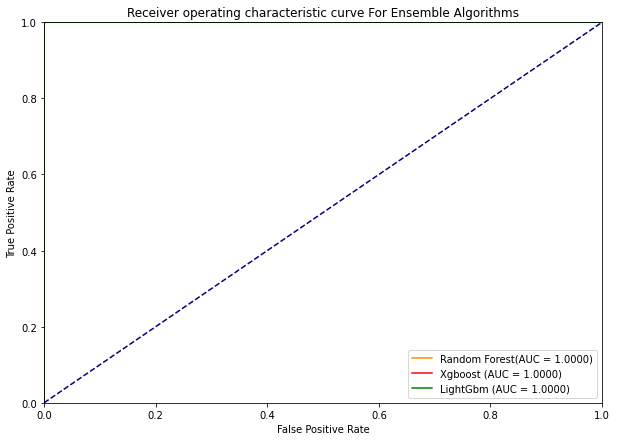

In [59]:
# ROC Curve for Ensemble Algorithms
Q = rf.predict_proba(x_test)[:,1]
R = xg.predict_proba(x_test)[:,1]
S = lg.predict_proba(x_test)[:,1]
#ROC PLOT
fpr, tpr, _ = roc_curve(y_test, Q)
roc_auc = auc(fpr,tpr)
fpr1, tpr1, _ = roc_curve(y_test, R)
roc_auc1 = auc(fpr1,tpr1)
fpr2, tpr2, _ = roc_curve(y_test, S)
roc_auc2 = auc(fpr2,tpr2)
plt.figure(figsize=(10,7)) 

plt.plot(fpr, tpr, color='darkorange', label='Random Forest(AUC = %0.4f)' % roc_auc)
plt.plot(fpr1, tpr1, color='red', label='Xgboost (AUC = %0.4f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='green', label='LightGbm (AUC = %0.4f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--' )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve For Ensemble Algorithms')
plt.legend(loc="lower right")
plt.show()

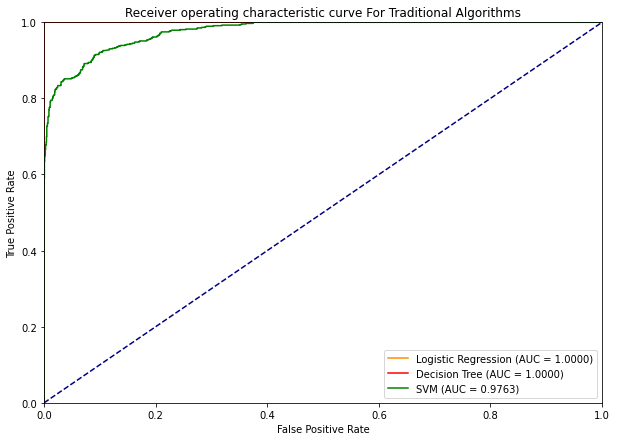

In [60]:
# ROC Curve for Traditional Algorithms
X = lg.predict_proba(x_test)[:,1]
Y = dt.predict_proba(x_test)[:,1]
Z = svm.predict_proba(x_test)[:,1]
#ROC PLOT
fpr, tpr, _ = roc_curve(y_test, X)
roc_auc = auc(fpr,tpr)
fpr1, tpr1, _ = roc_curve(y_test, Y)
roc_auc1 = auc(fpr1,tpr1)
fpr2, tpr2, _ = roc_curve(y_test, Z)
roc_auc2 = auc(fpr2,tpr2)
plt.figure(figsize=(10,7)) 

plt.plot(fpr, tpr, color='darkorange', label='Logistic Regression (AUC = %0.4f)' % roc_auc)
plt.plot(fpr1, tpr1, color='red', label='Decision Tree (AUC = %0.4f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='green', label='SVM (AUC = %0.4f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--' )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve For Traditional Algorithms')
plt.legend(loc="lower right")
plt.show()

79/79 [==============================] - 0s 2ms/step


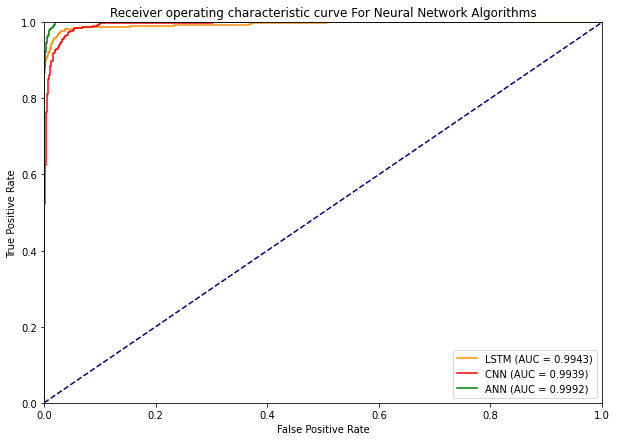

In [61]:
J= lstm.predict(x_test)[:,0]
Z = ann.predict_proba(x_test)[:,1]
R= cnn.predict(x_test)[:,0]
fpr, tpr, _ = roc_curve(y_test, J)
roc_auc = auc(fpr,tpr)
fpr1, tpr1, _ = roc_curve(y_test, R)
roc_auc1 = auc(fpr1,tpr1)
fpr2, tpr2, _ = roc_curve(y_test, Z)
roc_auc2 = auc(fpr2,tpr2)
plt.figure(figsize=(10,7)) 

plt.plot(fpr, tpr, color='darkorange', label='LSTM (AUC = %0.4f)' % roc_auc)
plt.plot(fpr1, tpr1, color='red', label='CNN (AUC = %0.4f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='green', label='ANN (AUC = %0.4f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--' )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve For Neural Network Algorithms')
plt.legend(loc="lower right")
plt.show()

# Fine tuning Ensemble Algorithms

In [62]:
par_rf= {
    'n_estimators':[150,100,250,300,400],  
    'min_samples_leaf':[1,2,4,6],
    'max_depth':[1,2,5,10],
    'min_samples_split':[2,4,6]
    
}

grid_rf= GridSearchCV(rf, par_rf, n_jobs=-1, cv=5,scoring='accuracy')
grid_rf.fit(x_train,y_train)
best_rf= grid_rf.best_params_
print('Best parameters  for RF found:',best_rf)
rf=grid_rf.best_estimator_
rf.fit(x_train,y_train)
y_pred_rf=rf.predict(x_test)
print('Accuracy Score Randm forest Model:',accuracy_score(y_test,y_pred_rf))
print('Precision Score Random forest Model:',precision_score(y_test,y_pred_rf))
print('Recall Score Random forest Model:',recall_score(y_test,y_pred_rf))
print('F1-Score Random forest Model:',f1_score(y_test,y_pred_rf))
print()
print()




par_xg= {
    'n_estimators':[150,100,300,400],  
    'learning_rate':[0.1,0.001,1.0],
    'max_depth':[3,5,7],
    'subsample':[0.6,0.8,1.0] 
}
grid_xg= GridSearchCV(xg, par_xg, n_jobs=-1, cv=5,scoring='accuracy')
grid_xg.fit(x_train,y_train)
best_xg= grid_xg.best_params_
print('Best parameters  for Xgboost found:',best_xg)
xg=grid_xg.best_estimator_
xg.fit(x_train,y_train)
y_pred_xg=xg.predict(x_test)
print('Accuracy Score Xgboost Model:',accuracy_score(y_test,y_pred_xg))
print('Precision Score Xgboost Model:',precision_score(y_test,y_pred_xg))
print('Recall Score Xgboost Model:',recall_score(y_test,y_pred_xg))
print('F1-Score Xgbost Model:',f1_score(y_test,y_pred_xg))
print()
print()



par_lg= {
    'n_estimators':[100,300,400],  
    'learning_rate':[0.1,0.2,0.4],
    'num_leaves':[5,10,15],
    'boosting_type':['dart','rf','gbdt']
    
}

grid_lg= GridSearchCV(lg, par_lg, n_jobs=-1, cv=5,scoring='accuracy')
grid_lg.fit(x_train,y_train)
best_lg= grid_lg.best_params_
print('Best parameters  for lightgbm found:',best_lg)
lg=grid_lg.best_estimator_
lg.fit(x_train,y_train)
y_pred_lg=lg.predict(x_test)
print('Accuracy Score LightGBM Model:',accuracy_score(y_test,y_pred_lg))
print('Precision Score LightGBM Model:',precision_score(y_test,y_pred_lg))
print('Recall Score LightGBM Model:',recall_score(y_test,y_pred_lg))
print('F1-Score LightGBM Model:',f1_score(y_test,y_pred_lg))

Best parameters  for RF found: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Accuracy Score Randm forest Model: 1.0
Precision Score Random forest Model: 1.0
Recall Score Random forest Model: 1.0
F1-Score Random forest Model: 1.0


Best parameters  for Xgboost found: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.6}
Accuracy Score Xgboost Model: 1.0
Precision Score Xgboost Model: 1.0
Recall Score Xgboost Model: 1.0
F1-Score Xgbost Model: 1.0


Best parameters  for lightgbm found: {'boosting_type': 'dart', 'learning_rate': 0.4, 'n_estimators': 300, 'num_leaves': 10}
Accuracy Score Xgboost Model: 0.9996023856858847
Precision Score Xgboost Model: 0.9985163204747775
Recall Score Xgboost Model: 1.0
F1-Score Xgbost Model: 0.9992576095025985


# Fine tuning Traditional Algorithms

In [63]:
par_lr= {
    'fit_intercept':[x for x in range(1,20)],
    'solver':['saga','liblinear'],
    'penalty':['l1','l2'],
    'C':[0.001,0.01,0.1,1,10],
    
}

grid_lr= GridSearchCV(lr, par_lr, n_jobs=-1, cv=5,scoring='accuracy')
grid_lr.fit(x_train,y_train)
best_lr=grid_lr.best_params_
print('Best parameters  for LR found:', best_lr)
lr=grid_lr.best_estimator_
lr.fit(x_train,y_train)
y_pred_lr=lr.predict(x_test)
print('Accuracy Score Linear regression model:',accuracy_score(y_test,y_pred_lr))
print('Precision Score Linear regression model:',precision_score(y_test,y_pred_lr))
print('Recall Score Linear regression model:',recall_score(y_test,y_pred_lr))
print('F1-Score Linear regression model:',f1_score(y_test,y_pred_lr))
print()
print()


par_svm= {
    'kernel':['linear','polynomial','radial'],
    'C':[0.1,1,10],
    'gamma':['auto','scale']
}

grid_svm= GridSearchCV(svm, par_svm, n_jobs=-1, cv=5,scoring='accuracy')
grid_svm.fit(x_train,y_train)
best_svm=grid_svm.best_params_
print('Best parameters  for SVM found:', best_svm)
svm=grid_svm.best_estimator_
svm.fit(x_train,y_train)
y_pred_svm=svm.predict(x_test)
print('Accuracy Score SVM Model:',accuracy_score(y_test,y_pred_svm))
print('Precision Score SVM Model:',precision_score(y_test,y_pred_svm))
print('Recall Score SVM Model:',recall_score(y_test,y_pred_svm))
print('F1-Score SVM Model:',f1_score(y_test,y_pred_svm))
print()
print()



par_dt= {
    'max_depth':[5,10,20],
    'min_samples_split':[2,4,6],
    'max_features':[2,5,6],
    'min_samples_leaf':[2,4,6]
}

grid_dt= GridSearchCV(dt, par_dt, n_jobs=-1, cv=5,scoring='accuracy')
grid_dt.fit(x_train,y_train)
best_dt=grid_dt.best_params_
print('Best parameters  for DT found:', best_dt)
dt=grid_dt.best_estimator_
dt.fit(x_train,y_train)
y_pred_dt=dt.predict(x_test)
print('Accuracy Score:',accuracy_score(y_test,y_pred_dt))
print('Precision Score:',precision_score(y_test,y_pred_dt))
print('Recall Score:',recall_score(y_test,y_pred_dt))
print('F1-Score:',f1_score(y_test,y_pred_dt))

Best parameters  for LR found: {'C': 10, 'fit_intercept': 3, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy Score Linear regression model: 0.9960238568588469
Precision Score Linear regression model: 0.9984962406015038
Recall Score Linear regression model: 0.986627043090639
F1-Score Linear regression model: 0.992526158445441


Best parameters  for SVM found: {'C': 10, 'gamma': 'auto', 'kernel': 'linear'}
Accuracy Score SVM Model: 0.994831013916501
Precision Score SVM Model: 0.9984894259818731
Recall Score SVM Model: 0.9821693907875185
F1-Score SVM Model: 0.9902621722846441


Best parameters  for DT found: {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 2}
Accuracy Score: 1.0
Precision Score: 1.0
Recall Score: 1.0
F1-Score: 1.0


# Fine tuning Neural Networks

In [82]:
par_ann= {
    'hidden_layer_sizes':[(100,),(50,50),(50,100,50)],
    'activation':['relu','tanh','logistic'],
    'solver':['lbfgs','sgd','adam'],
    'learning_rate':['adaptive','constant'],
    'alpha':[0.0001,0.001,0.1]
    
}

grid_ann= GridSearchCV(ann, par_ann, n_jobs=-1, cv=5,scoring='accuracy')
grid_ann.fit(x_train,y_train)
best_ann=grid_ann.best_params_
print('Best parameters  for ANN found:', best_ann)
ann=grid_ann.best_estimator_
ann.fit(x_train,y_train)
y_pred_ann=ann.predict(x_test)
print('Accuracy Score:',accuracy_score(y_test,y_pred_ann))
print('Precision Score:',precision_score(y_test,y_pred_ann))
print('Recall Score:',recall_score(y_test,y_pred_ann))
print('F1-Score:',f1_score(y_test,y_pred_ann))

{'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'learning_rates': 'constant', 'alpha': 0.0001}
Accuracy Score: 0.990854870775348
Precision Score: 0.9807692307692307
Recall Score: 0.9851411589895989
F1-Score: 0.9829503335804299


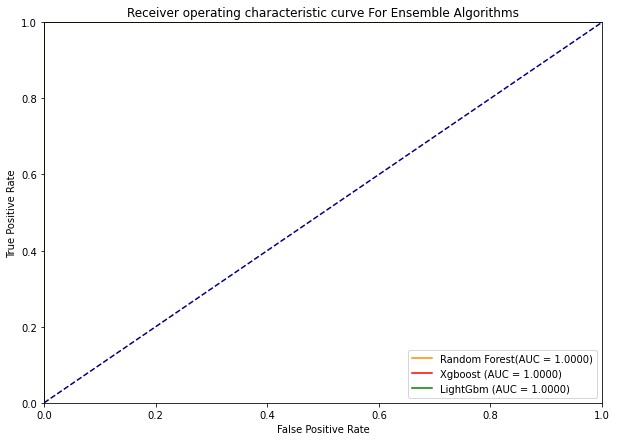

In [83]:
# ROC Curve for Ensemble Algorithms
Q = rf.predict_proba(x_test)[:,1]
R = xg.predict_proba(x_test)[:,1]
S = lg.predict_proba(x_test)[:,1]
#ROC PLOT
fpr, tpr, _ = roc_curve(y_test, Q)
roc_auc = auc(fpr,tpr)
fpr1, tpr1, _ = roc_curve(y_test, R)
roc_auc1 = auc(fpr1,tpr1)
fpr2, tpr2, _ = roc_curve(y_test, S)
roc_auc2 = auc(fpr2,tpr2)
plt.figure(figsize=(10,7)) 

plt.plot(fpr, tpr, color='darkorange', label='Random Forest(AUC = %0.4f)' % roc_auc)
plt.plot(fpr1, tpr1, color='red', label='Xgboost (AUC = %0.4f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='green', label='LightGbm (AUC = %0.4f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--' )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve For Ensemble Algorithms')
plt.legend(loc="lower right")
plt.show()

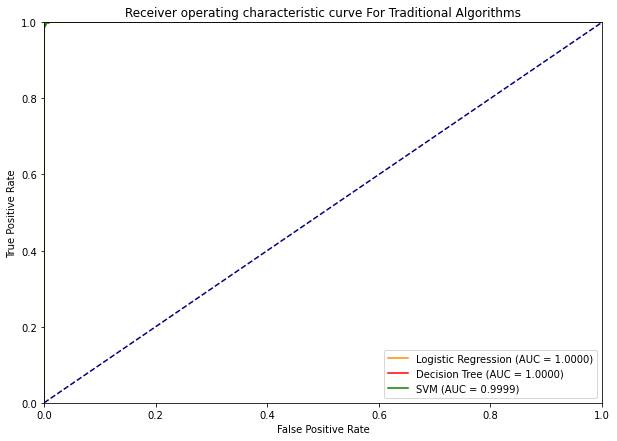

In [84]:
# ROC Curve for Traditional Algorithms
X = lg.predict_proba(x_test)[:,1]
Y = dt.predict_proba(x_test)[:,1]
Z = svm.predict_proba(x_test)[:,1]
#ROC PLOT
fpr, tpr, _ = roc_curve(y_test, X)
roc_auc = auc(fpr,tpr)
fpr1, tpr1, _ = roc_curve(y_test, Y)
roc_auc1 = auc(fpr1,tpr1)
fpr2, tpr2, _ = roc_curve(y_test, Z)
roc_auc2 = auc(fpr2,tpr2)
plt.figure(figsize=(10,7)) 

plt.plot(fpr, tpr, color='darkorange', label='Logistic Regression (AUC = %0.4f)' % roc_auc)
plt.plot(fpr1, tpr1, color='red', label='Decision Tree (AUC = %0.4f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='green', label='SVM (AUC = %0.4f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--' )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve For Traditional Algorithms')
plt.legend(loc="lower right")
plt.show()

79/79 [==============================] - 3s 33ms/step


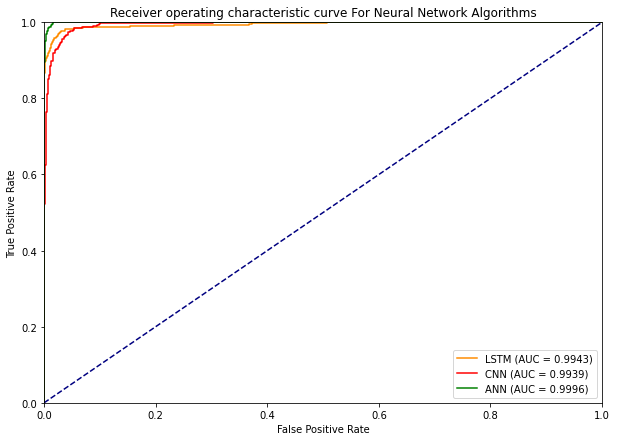

In [85]:
J= lstm.predict(x_test)[:,0]
Z = ann.predict_proba(x_test)[:,1]
R= cnn.predict(x_test)[:,0]
fpr, tpr, _ = roc_curve(y_test, J)
roc_auc = auc(fpr,tpr)
fpr1, tpr1, _ = roc_curve(y_test, R)
roc_auc1 = auc(fpr1,tpr1)
fpr2, tpr2, _ = roc_curve(y_test, Z)
roc_auc2 = auc(fpr2,tpr2)
plt.figure(figsize=(10,7)) 

plt.plot(fpr, tpr, color='darkorange', label='LSTM (AUC = %0.4f)' % roc_auc)
plt.plot(fpr1, tpr1, color='red', label='CNN (AUC = %0.4f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='green', label='ANN (AUC = %0.4f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--' )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve For Neural Network Algorithms')
plt.legend(loc="lower right")
plt.show()